# Aim: To Detect Multi-collinearity

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy
import seaborn as sns

In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [5]:
import sys
import os
import math
import csv
import json

## Helper Methods and Variables

In [6]:
def sentence_to_snake_case(sentence):
    # Split the sentence into words, convert to lowercase, and join with underscores
    snake_case = '_'.join(word.lower() for word in sentence.split())
    return snake_case

In [7]:
useless_cols = ['CustomerID', 'Count', 'Country', 'State', 'City', \
                'Zip Code', 'Lat Long', 'Churn Score', 'Churn Label', 'CLTV', 'Churn Reason', 'Total Charges']

In [8]:
y_cols = ['Churn Value', 'Tenure Months']

In [9]:
short_term_cols = ['Phone Service', 'Multiple Lines', 'Internet Service', \
                   'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', \
                   'Streaming TV', 'Streaming Movies']

## Prepare the data

In [10]:
os.getcwd()

'C:\\D Drive\\University of Washington\\Study\\Quarter 2\\DATA 557\\Project\\ML'

In [11]:
data = pd.read_csv('../data/Telco_customer_churn_cleaned.csv')

In [12]:
data.head()

,Unnamed: 0,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,...,Month-to-month,Yes,Electronic check,99.65,820.50,Yes,1,86,5372,Moved
3,3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,Yes,1,89,5340,Competitor had better devices


In [13]:
data = data.rename(columns = lambda column: sentence_to_snake_case(column))

In [14]:
data.head()

,unnamed:_0,customerid,count,country,state,city,zip_code,lat_long,latitude,longitude,...,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn_label,churn_value,churn_score,cltv,churn_reason
0,0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,...,Month-to-month,Yes,Electronic check,99.65,820.50,Yes,1,86,5372,Moved
3,3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,Yes,1,89,5340,Competitor had better devices


In [15]:
# Leaving in Customer ID just in case
useless_cols = [sentence_to_snake_case(column) for column in useless_cols]

In [16]:
y_cols = [sentence_to_snake_case(column) for column in y_cols]

In [17]:
y_cols

['churn_value', 'tenure_months']

In [18]:
# Drop the first column "Unnamed" and the useless columns
data = data.drop([data.columns[0]] + useless_cols, axis=1)

In [19]:
data.head()

,latitude,longitude,gender,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,internet_service,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,churn_value
0,33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,...,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,1
1,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,...,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,1
2,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,...,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,1
3,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,...,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,1
4,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,1


## Get either the best case or worst case scenario

### The data being set from here will decide how the model will treat its unknown churn customers

**Our y is a check on whether the user will churn within 12 months or not**

In [20]:
def best_case_churn(row):
    # User has definitely not churned within the 12 months
    if row['tenure_months'] >= 12: return 0
    # User has definitely churned within the 12 months
    if row['tenure_months'] < 12 and row['churn_value'] == 1: return 1
    # Best case assumption
    return 0

In [21]:
def worst_case_churn(row):
    # User has definitely not churned within the 12 months
    if row['tenure_months'] >= 12: return 0
    # User has definitely churned within the 12 months
    if row['tenure_months'] < 12 and row['churn_value'] == 1: return 1
    # Best case assumption
    return 1

### Switch the following line to switch between best case and worst case

In [22]:
main_y_col = 'churn'

In [23]:
data[main_y_col] = data.apply(worst_case_churn, axis=1)

In [24]:
data['tenure_months'].unique()

array([ 2,  8, 28, 49, 10,  1, 47, 17,  5, 34, 11, 15, 18,  9,  7, 12, 25,
       68, 55, 37,  3, 27, 20,  4, 58, 53, 13,  6, 19, 59, 16, 52, 24, 32,
       38, 54, 43, 63, 21, 69, 22, 61, 60, 48, 40, 23, 39, 35, 56, 65, 33,
       30, 45, 46, 62, 70, 50, 44, 71, 26, 14, 41, 66, 64, 29, 42, 67, 51,
       31, 57, 36, 72,  0], dtype=int64)

In [25]:
y_cols.extend([main_y_col])
y_cols

,churn_value,tenure_months,churn
0,1,2,1
1,1,2,1
2,1,8,1
3,1,28,0
4,1,49,0
...,...,...,...
7038,0,72,0
7039,0,24,0
7040,0,72,0
7041,0,11,1


In [26]:
y_cols

['churn_value', 'tenure_months', 'churn']

## Divide the dataset into train and test test

In [31]:
RNG = np.random.RandomState(seed=420)

In [32]:
train, test = train_test_split(data, test_size=0.1, shuffle=True, random_state=RNG)

In [33]:
train.shape

(6338, 22)

In [34]:
test.shape

(705, 22)

## Pre-process the data

### Normalize

**Remember to save normalization details of train data, to apply to test data**

Pipeline transforms automatically do so for us.

In [27]:
# Prepare to Standardize all numeric columns except Churn Value
numeric_cols = list(data.select_dtypes(include=['int64', 'float64']))
numeric_cols = [column for column in numeric_cols if column not in y_cols]
numeric_cols

['latitude', 'longitude', 'monthly_charges']

In [28]:
# Pipeline is to maintain consistency
standardization_transformer = Pipeline(steps=[('scaler', StandardScaler())])

In [29]:
# ColumnTransformer helps standardize only selected columns
preprocessor = ColumnTransformer(
    transformers=[('num', standardization_transformer, numeric_cols)],
    remainder='passthrough'  # This leaves the rest of the columns in the dataset unchanged
)

In [35]:
preprocessed_train_array = preprocessor.fit(train).transform(train)

In [36]:
preprocessed_columns = [col.split('__')[1] for col in preprocessor.get_feature_names_out()]
# preprocessed_columns

## Warning!! Bad Coding Practice Alert

In [50]:
final_columns = [column for column in train.columns if (column not in y_cols or column == main_y_col)]
# final_columns

In [37]:
# Instead of mapping preprocessed_columns with the old data.columns and getting the dtypes
# for now we will proceed with hard-coding logic
# Because columns that have prefix num are obviously float
# While other columns are either object or can be treated as object (except Churn Value which will separately be made int64)
preprocessed_column_types = ['float64' if col.split('__')[0]=='num' else 'object' for col in preprocessor.get_feature_names_out()]

In [38]:
preprocessed_column_types[-1] = 'int64'

In [39]:
preprocessed_column_dtypes = {preprocessed_columns[i]: preprocessed_column_types[i] for i in range(len(preprocessed_columns))}

In [41]:
preprocessed_train = pd.DataFrame(data=preprocessed_train_array, columns=preprocessed_columns)
preprocessed_train = preprocessed_train.astype(preprocessed_column_dtypes)

In [42]:
preprocessed_train.head()

,latitude,longitude,monthly_charges,gender,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,churn_value,churn
0,-0.498158,-0.371946,1.295086,Male,No,Yes,Yes,60,Yes,Yes,...,Yes,No,Yes,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),0,0
1,-1.423199,1.358143,-1.516232,Female,No,No,No,20,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Credit card (automatic),0,0
2,0.444907,-1.026476,0.965322,Male,No,No,No,17,Yes,No,...,No,No,No,Yes,Yes,Month-to-month,No,Electronic check,1,0
3,1.202459,-0.117674,-1.514566,Female,No,No,No,29,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0,0
4,-0.899465,0.660012,0.653879,Female,No,No,No,49,Yes,Yes,...,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,0,0


In [54]:
preprocessed_train = preprocessed_train[final_columns]

In [43]:
preprocessed_test_array = preprocessor.transform(test)

In [44]:
preprocessed_test = pd.DataFrame(data=preprocessed_test_array, columns=preprocessed_columns)
preprocessed_test = preprocessed_test.astype(preprocessed_column_dtypes)

In [45]:
preprocessed_test.head()

,latitude,longitude,monthly_charges,gender,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,churn_value,churn
0,1.077896,-1.383298,1.331726,Female,Yes,Yes,No,62,Yes,Yes,...,No,Yes,No,Yes,Yes,One year,Yes,Electronic check,0,0
1,-0.903949,0.703809,-1.479591,Male,No,No,No,47,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),0,0
2,-0.863037,0.738054,-0.165534,Male,No,No,No,9,Yes,Yes,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,0,1
3,0.495985,-1.031974,0.868725,Female,Yes,No,No,32,Yes,No,...,No,No,No,Yes,Yes,Month-to-month,No,Electronic check,0,0
4,0.898898,-0.799467,0.184215,Female,No,No,No,4,Yes,No,...,No,No,No,No,No,Month-to-month,No,Electronic check,1,1


In [55]:
preprocessed_test = preprocessed_test[final_columns]

In [57]:
# preprocessed_test.head()

## Get VIF Data

In [59]:
def matrixFormulaGenerator(data, y_cols = [''], main_y_col=''):
    x_cols = [column for column in list(data.columns) if column not in y_cols]
    formula = f'{main_y_col} ~'
    for index, column in enumerate(x_cols):
        if index != 0: formula = f'{formula} +'
        if data.dtypes[column] in ['int64', 'float64']: formula = f'{formula} {column}'
        else: formula = f'{formula} {column}'
    return formula

In [60]:
matrix_formula = matrixFormulaGenerator(preprocessed_train, y_cols, main_y_col)
matrix_formula

'churn ~ latitude + longitude + gender + senior_citizen + partner + dependents + phone_service + multiple_lines + internet_service + online_security + online_backup + device_protection + tech_support + streaming_tv + streaming_movies + contract + paperless_billing + payment_method + monthly_charges'

In [62]:
from patsy import dmatrices
y, X = dmatrices(matrix_formula, data=preprocessed_train, return_type='dataframe')

In [65]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

C:\Users\hnaid\anaconda3\envs\data557\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\hnaid\anaconda3\envs\data557\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,0.000000,Intercept
1,1.001864,gender[T.Male]
2,1.129362,senior_citizen[T.Yes]
3,1.294635,partner[T.Yes]
4,1.236539,dependents[T.Yes]
5,inf,phone_service[T.Yes]
6,inf,multiple_lines[T.No phone service]
7,7.251631,multiple_lines[T.Yes]
8,149.531531,internet_service[T.Fiber optic]
9,inf,internet_service[T.No]


In [71]:
data['internet_service'].value_counts()

internet_service
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

In [63]:
# vif_data["VIF"] = [variance_inflation_factor(preprocessed_train.values, i) for i in range(len(preprocessed_train.columns))] 

## Infinity VIF!!!

### Need to search for variables that are perfectly correlated

In [72]:
# preprocessed_train[]

In [102]:
from patsy import dmatrices
sub_formula = 'churn ~ latitude + longitude + gender + senior_citizen + partner + dependents + phone_service + internet_service + contract + paperless_billing + payment_method + monthly_charges'
y_sub, X_sub = dmatrices(sub_formula, data=preprocessed_train, return_type='dataframe')

In [103]:
vif_sub = pd.DataFrame()
vif_sub["VIF Factor"] = [variance_inflation_factor(X_sub.values, i) for i in range(X_sub.shape[1])]
vif_sub["features"] = X_sub.columns
vif_sub

,VIF Factor,features
0,28.726973,Intercept
1,1.001172,gender[T.Male]
2,1.116094,senior_citizen[T.Yes]
3,1.286602,partner[T.Yes]
4,1.233634,dependents[T.Yes]
5,1.702527,phone_service[T.Yes]
6,4.014428,internet_service[T.Fiber optic]
7,5.253013,internet_service[T.No]
8,1.337509,contract[T.One year]
9,1.776612,contract[T.Two year]


### Internet Service is Perfectly Correlated

In [95]:
preprocessed_train[preprocessed_train['internet_service'] == 'No'][['internet_service', 'streaming_tv']]

,internet_service,streaming_tv
1,No,No internet service
3,No,No internet service
9,No,No internet service
10,No,No internet service
12,No,No internet service
...,...,...
6331,No,No internet service
6333,No,No internet service
6334,No,No internet service
6336,No,No internet service


### Get Correlation Matrix

In [105]:
object_columns = [column for column in preprocessed_train.columns if preprocessed_train[column].dtype=='object']

In [107]:
# object_columns

In [108]:
preprocessed_train_encoded = pd.get_dummies(preprocessed_train, columns=object_columns)

In [109]:
preprocessed_train_encoded

,latitude,longitude,monthly_charges,churn,gender_Female,gender_Male,senior_citizen_No,senior_citizen_Yes,partner_No,partner_Yes,...,streaming_movies_Yes,contract_Month-to-month,contract_One year,contract_Two year,paperless_billing_No,paperless_billing_Yes,payment_method_Bank transfer (automatic),payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check
0,-0.498158,-0.371946,1.295086,0,False,True,True,False,False,True,...,True,True,False,False,False,True,True,False,False,False
1,-1.423199,1.358143,-1.516232,0,True,False,True,False,True,False,...,False,False,True,False,False,True,False,True,False,False
2,0.444907,-1.026476,0.965322,0,False,True,True,False,True,False,...,True,True,False,False,True,False,False,False,True,False
3,1.202459,-0.117674,-1.514566,0,True,False,True,False,True,False,...,False,False,False,True,True,False,False,False,False,True
4,-0.899465,0.660012,0.653879,0,True,False,True,False,True,False,...,True,True,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6333,0.180098,-0.149465,-1.512901,0,False,True,True,False,False,True,...,False,False,True,False,False,True,True,False,False,False
6334,-1.035110,1.309279,-1.517897,1,True,False,True,False,False,True,...,False,True,False,False,True,False,False,False,False,True
6335,-0.844825,0.647366,-0.317092,0,False,True,True,False,False,True,...,True,False,True,False,False,True,False,True,False,False
6336,0.392377,-0.207744,-1.489584,0,False,True,True,False,True,False,...,False,False,True,False,True,False,False,True,False,False


In [110]:
correlation_matrix = preprocessed_train_encoded.corr()

<Axes: >

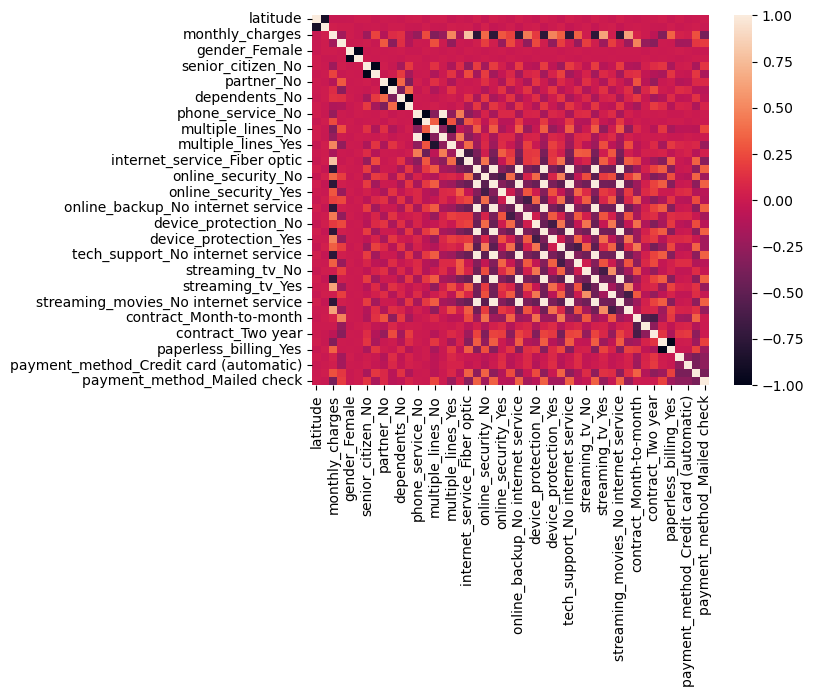

In [114]:
sns.heatmap(correlation_matrix)

In [127]:
correlation_matrix[['phone_service_No', 'phone_service_Yes', 'internet_service_DSL', 'internet_service_Fiber optic', 'internet_service_No']]

,phone_service_No,phone_service_Yes,internet_service_DSL,internet_service_Fiber optic,internet_service_No
latitude,0.016060,-0.016060,-0.001763,-0.018709,0.024641
longitude,-0.015814,0.015814,0.013084,0.016137,-0.034617
monthly_charges,-0.245068,0.245068,-0.160900,0.786548,-0.764355
churn,0.000598,-0.000598,-0.006502,-0.017470,0.028620
gender_Female,-0.010135,0.010135,-0.011009,0.009234,0.001566
gender_Male,0.010135,-0.010135,0.011009,-0.009234,-0.001566
senior_citizen_No,0.005898,-0.005898,0.103784,-0.248982,0.180880
senior_citizen_Yes,-0.005898,0.005898,-0.103784,0.248982,-0.180880
partner_No,0.024978,-0.024978,0.006365,-0.011294,0.006290
partner_Yes,-0.024978,0.024978,-0.006365,0.011294,-0.006290
